In [509]:
from local_functions import *
import geopandas as gpd
import pandas as pd
from matplotlib_scalebar.scalebar import ScaleBar
import contextily as cx
from shapely.geometry import Point, LineString
from ipywidgets import *
import polars as pl
from plotnine import *
from mizani.formatters import *
import patchworklib as pw

pl.Config.set_tbl_rows(200)
pl.Config.set_fmt_float("full")
pl.Config.set_fmt_str_lengths(1000)
pl.Config.set_tbl_width_chars(1000)

polars.config.Config

In [510]:
regions = (
    pl.read_csv("data/regions.csv")
    .with_columns(
        pl.col("Region").str.replace("ns ", "ns"),
        pl.col("Novads").alias("Teritoriālā vienība")
    )
)

In [511]:
territorial_information = gpd.read_file("data/transformed/territorial_information_summary.geojson")

In [512]:
def format_value(value):
    if isinstance(value, str):
        return value
    if value:
        if value < 1:
            return str(round(value, 2))
        else:
            return str(round(value, 0))
    return ""

def draw_plot(measure, year):
    df = territorial_information[territorial_information.Gads == year]

    ax = df.plot(
        column = measure,
        legend = True,
        figsize=(20, 9)
    )
    df.apply(lambda x: ax.annotate(text=format_value(x[measure])+"\n"+x["Teritoriālā vienība"], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
    ax.set_title(f"{measure} ({year} gadā)", fontsize=14)
    ax.set_axis_off()
    return ax

In [513]:
interact(draw_plot, measure = sorted(list(territorial_information.columns)), year = (2014, 2024, 1))

interactive(children=(Dropdown(description='measure', options=('Autoceļu un pašvaldību ielu garums (asfaltbeto…

<function __main__.draw_plot(measure, year)>

In [514]:
def plot_expenses(region):
    measures = [
        'Pašvaldības izdevumi: Vispārējie valdības dienesti (Uzturēšanas izdevumi) (uz 1 iedz.)',
        'Pašvaldības izdevumi: Sabiedriskā kārtība un drošība (Uzturēšanas izdevumi) (uz 1 iedz.)',
        'Pašvaldības izdevumi: Ekonomiskā darbība (Uzturēšanas izdevumi) (uz 1 iedz.)',
        'Pašvaldības izdevumi: Teritoriju un mājokļu apsaimniekošana (Uzturēšanas izdevumi) (uz 1 iedz.)',
        'Pašvaldības izdevumi: Atpūta, kultūra un reliģija (Uzturēšanas izdevumi) (uz 1 iedz.)',
        'Pašvaldības izdevumi: Izglītība (Uzturēšanas izdevumi) (uz 1 iedz.)',
        'Pašvaldības izdevumi: Sociālā aizsardzība (Uzturēšanas izdevumi) (uz 1 iedz.)',
        #'Pašvaldības izdevumi: Aizsardzība (Uzturēšanas izdevumi) (uz 1 iedz.)',
        'Pašvaldības izdevumi: Vides aizsardzība (Uzturēšanas izdevumi) (uz 1 iedz.)',
        'Pašvaldības izdevumi: Veselība (Uzturēšanas izdevumi) (uz 1 iedz.)'
    ]
    values_df = (
        pl.from_dataframe(territorial_information[measures + ["Teritoriālā vienība", "Gads"]])
        .join(
            regions,
            on="Teritoriālā vienība",
            how="left"
        )
        .filter(
            pl.col("Region") == region
        )
        .unpivot(
            on=measures,
            index=["Teritoriālā vienība", "Gads", "Region"]
        )
        .filter(pl.col("Gads") == 2023)
        #.filter(pl.col("Teritoriālā vienība").is_in(["Rīga", "Jūrmala"]))
        .with_columns(
            pl.col("value").fill_null(0),
            pl.col("variable").str.replace("Pašvaldības izdevumi: ", "").str.replace(" \(Uzturēšanas izdevumi\) \(uz 1 iedz.\)", "").alias("Pašvaldības izdevumi")
        )
        .with_columns(
            (pl.col("value") / pl.col("value").sum().over("Teritoriālā vienība")).alias("pct_of_total"),
            pl.col("Teritoriālā vienība").str.contains(" nov.").cast(pl.Int32).alias("sort_order"),
            pl.col("value").sum().over("Teritoriālā vienība").alias("value_total")
        )
        .to_pandas()
    )
    
    y_axis_order = list(
        pl.from_dataframe(values_df)
        .group_by("Teritoriālā vienība")
        .agg(
            pl.col("value_total").max(),
            pl.col("sort_order").min()
        )
        .sort(
            ["sort_order", "value_total"],
            descending=[True, False]
        )
        .to_pandas()
        ["Teritoriālā vienība"]
    )
    
    values_df = (
        pl.from_dataframe(values_df)
        .with_columns(
            pl.col("Teritoriālā vienība").cast(pl.Enum(y_axis_order))
        )
        .to_pandas()
    )
    
    return(
        ggplot(values_df, aes(x="Teritoriālā vienība", y="Pašvaldības izdevumi", fill="value", label="value"))
        + geom_tile(show_legend=False)
        + theme(legend_position="right")  
        + coord_flip()
        + xlab("")
        + ylab("")
        + ggtitle(f"{region}: pašvaldību uzturēšanas izdevumi 2023. gadā (uz 1 iedz.)")
        + theme_minimal(base_size=16)
        + theme(
            figure_size=(12, 8),
            axis_text_x=element_text(rotation=45, hjust=1)
        )
        + scale_fill_continuous(labels=percent_format())
        + geom_label(
            aes(
                label=values_df["value"].apply(lambda x: f"{int(x):,}")
            ),
            stat="identity",
            fill="white",
            #format_string="{:.1f}%",
            size=14,
        )
    )

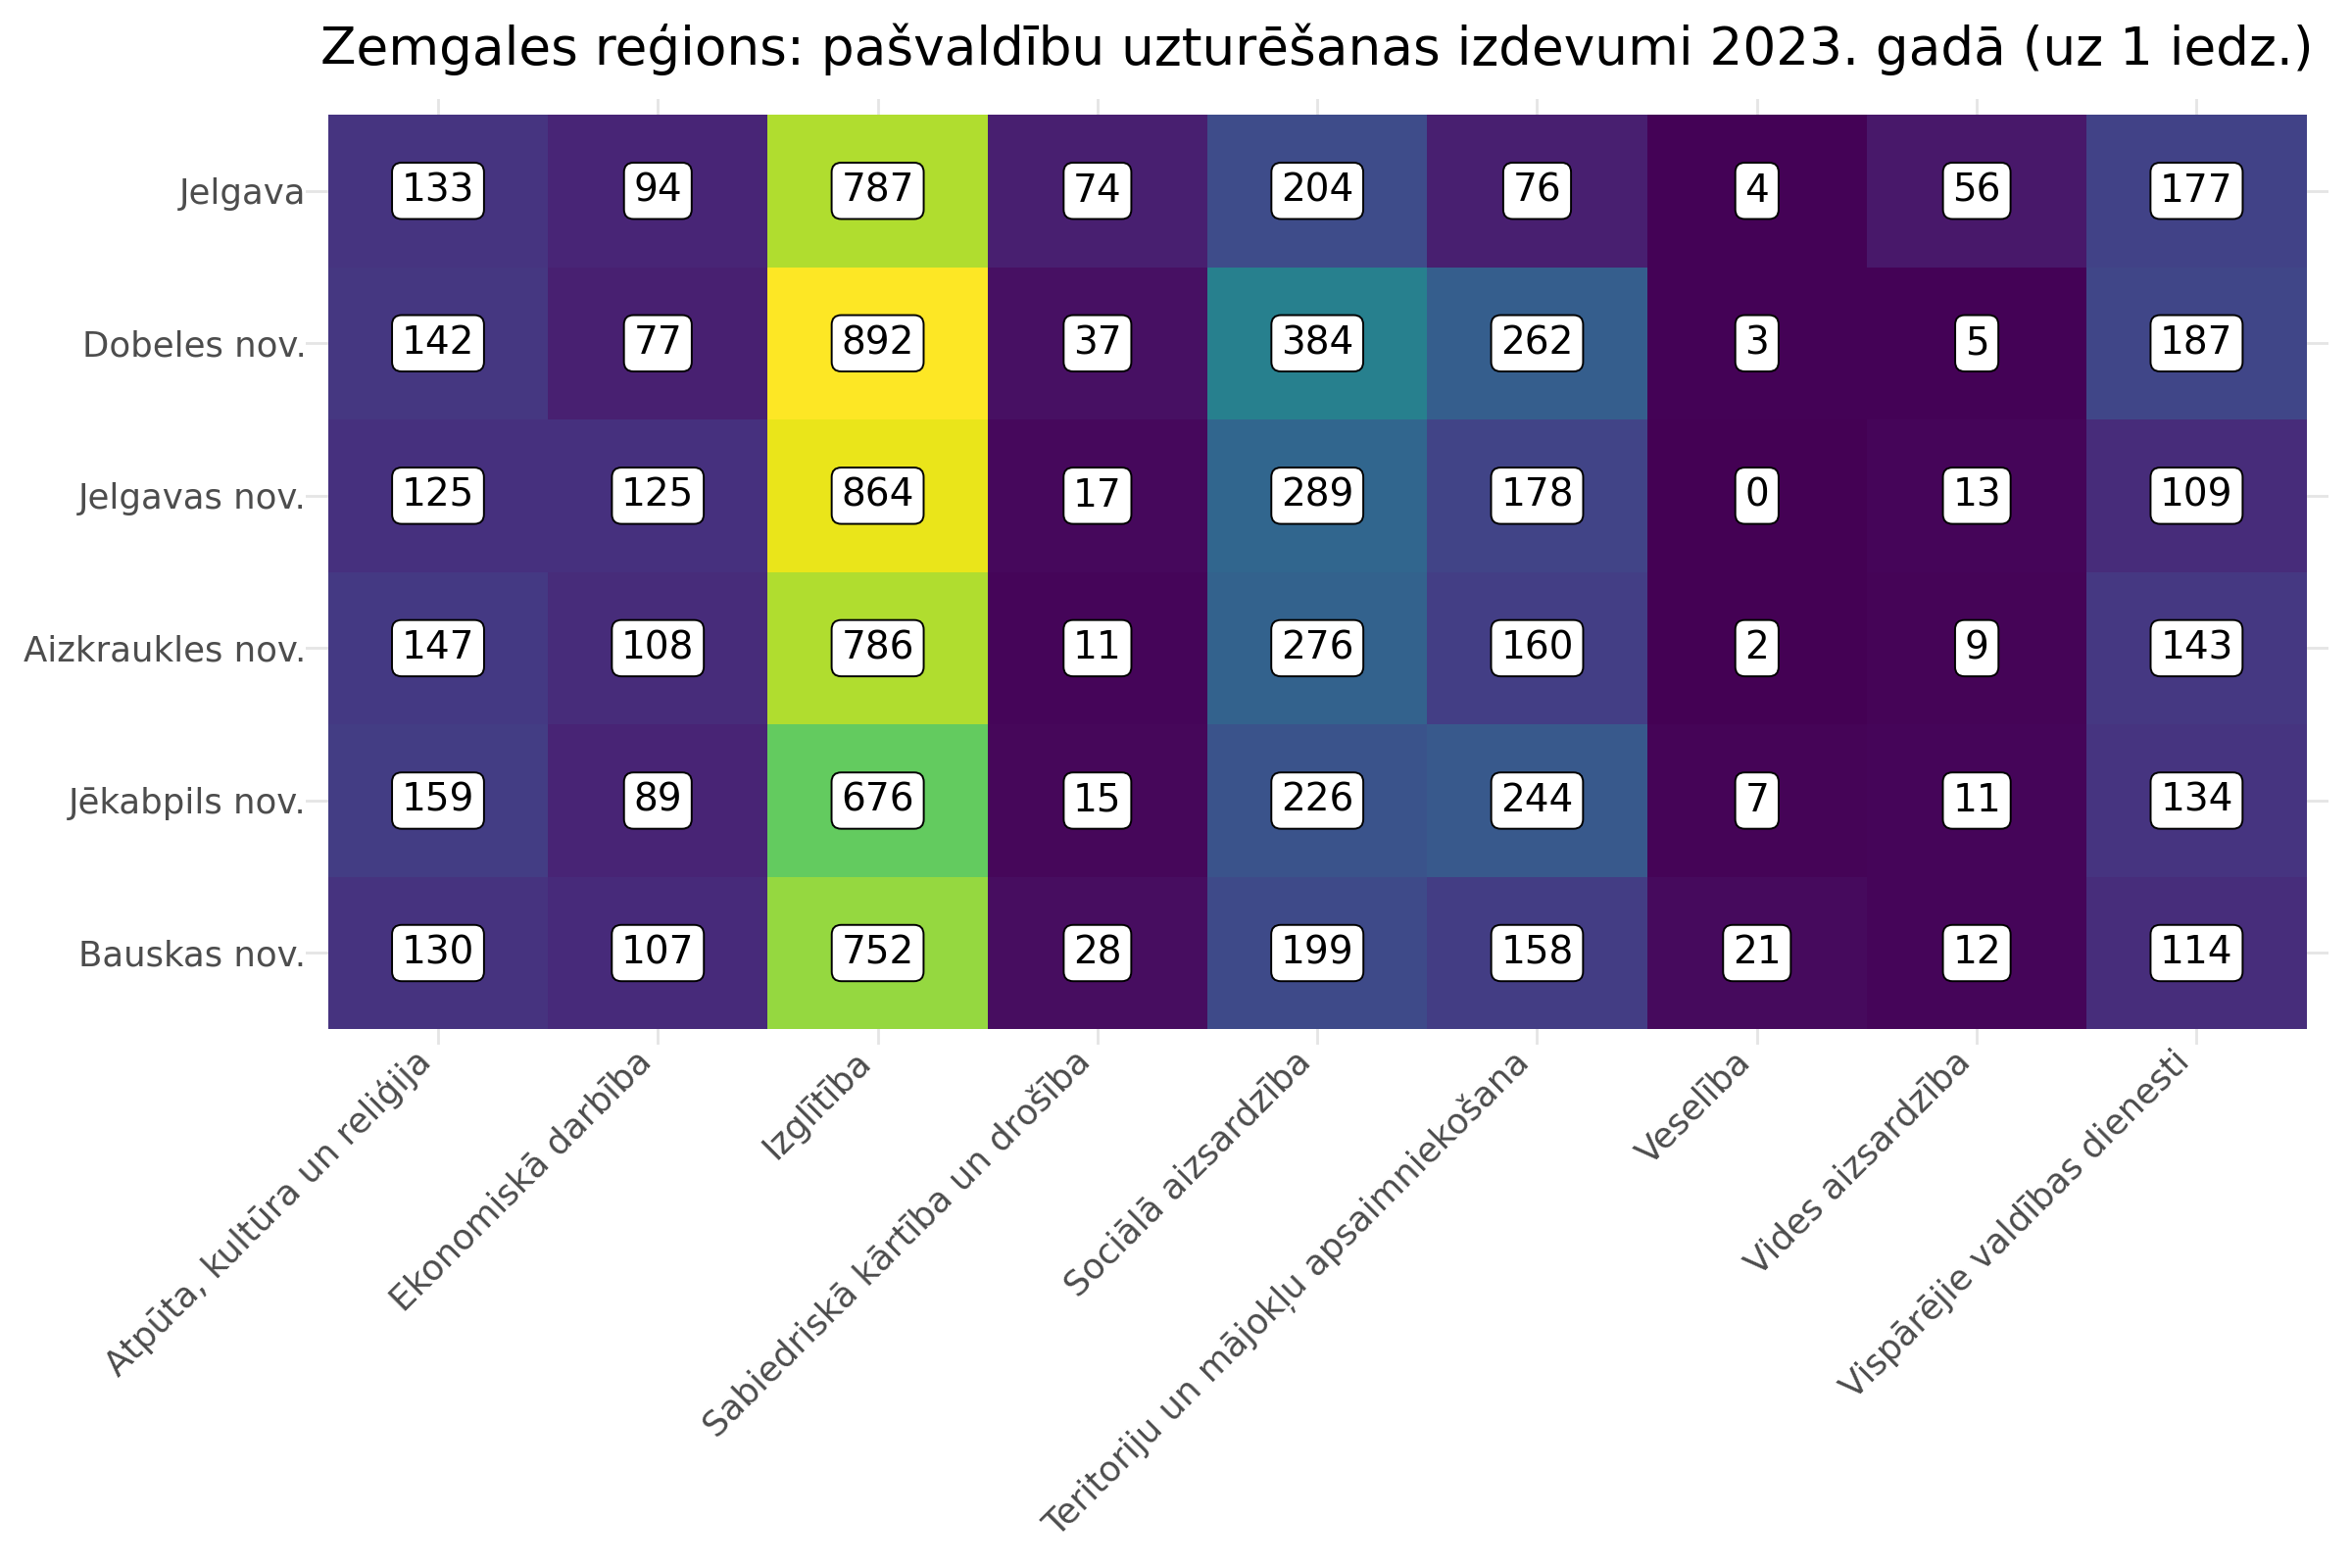

In [515]:
plot_expenses("Zemgales reģions")

In [516]:
(
    pl.from_dataframe(territorial_information[measures + ["Teritoriālā vienība", "Gads"]])
    .join(
        regions,
        on="Teritoriālā vienība",
        how="left"
    )
    .filter(pl.col("Gads") == 2023)
    .with_columns(
        pl.selectors.by_dtype(pl.NUMERIC_DTYPES).round()
    )
).write_csv("region_metrics_expenses.csv")

In [517]:
    df = territorial_information[territorial_information.Gads == 2023]

    ax = df.plot(
        column="Teritoriālā vienība",
        figsize=(20, 9)
    )
    df.apply(lambda x: ax.annotate(text=x["Teritoriālā vienība"], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
    ax.set_axis_off()

In [518]:
for c in sorted(territorial_information.columns):
    print(c)

Autoceļu un pašvaldību ielu garums (asfaltbetons)
Autoceļu un pašvaldību ielu garums (asfaltbetons) (uz 1 iedz.)
Autoceļu un pašvaldību ielu garums (šķembu)
Bezdarba līmenis
Bruto pievienotā vērtība uz vienu iedzīvotāju
Bērnudārzu skaits
Bērnudārzu skaits (uz 1000 iedz.)
Ceļu un ielu izdevumi (investīcijas)
Ceļu un ielu izdevumi (investīcijas) (uz 1 iedz.)
Ceļu un ielu izdevumi (investīcijas) (uz km^2)
Ceļu un ielu izdevumi (uzturēšana)
Ceļu un ielu izdevumi (uzturēšana) (uz 1 iedz.)
Ceļu un ielu izdevumi (uzturēšana) (uz km^2)
Daudzdzīvokļu ēku skaits
Ekonomiski aktīvi uzņēmumi (uz 1000 iedz.)
Ekonomiskās aktivitātes līmenis
Ekspluatācijā pieņemto dzīvokļu platība (tūkst. m2)
Ekspluatācijā pieņemto dzīvokļu platība (tūkst. m2) (uz 1 iedz.)
Gada vidējais iedzīvotāju skaits
Gads
Iedzīvotāji darbspējas vecumā
Iedzīvotāji darbspējas vecumā (%)
Iedzīvotāju dabiskais pieaugums
Iedzīvotāju skaita izmaiņas - pavisam
Iedzīvotāju skaita izmaiņas - pavisam (%)
Iedzīvotāju skaits gada sākumā
Iedz

In [519]:
pl.from_dataframe(territorial_information.drop("geometry", axis=1)).write_csv("metric_values.csv")

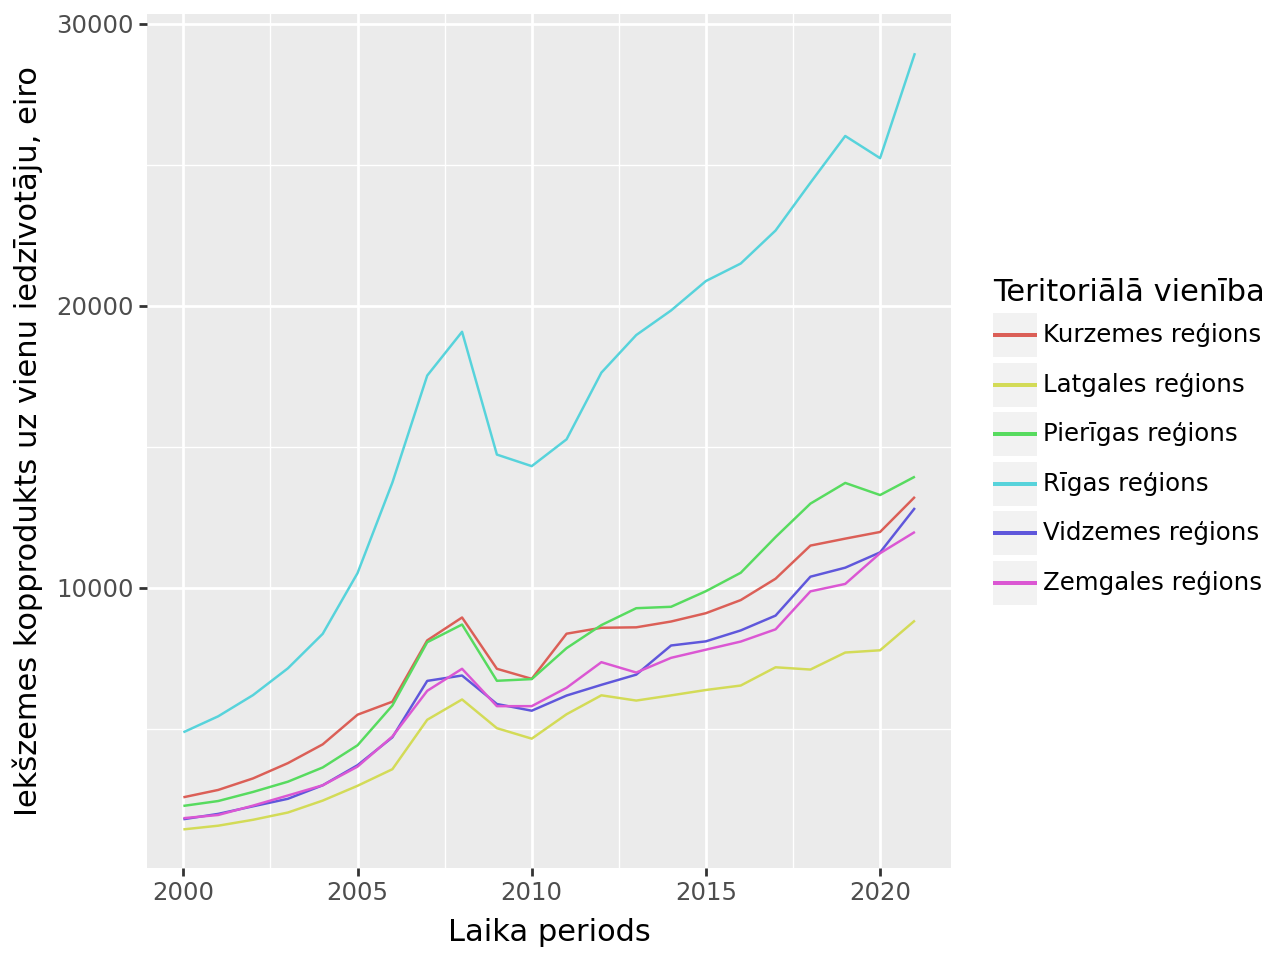

In [520]:
(
    ggplot(
        pl.read_csv("data/IKR010_20241222-151334.csv", separator=";", encoding="utf-8"),
        aes("Laika periods", "Iekšzemes kopprodukts uz vienu iedzīvotāju, eiro", color="Teritoriālā vienība")
    )
    + geom_line()
)

In [521]:
data = pd.read_csv("data/IKR010_20241222-151334.csv", sep=";", encoding="utf-8")

# Find the last value for each group to annotate
last_values = (
    data.groupby("Teritoriālā vienība")
    .apply(lambda df: df.iloc[-1])
    .reset_index(drop=True)
)

# Plot with the specified changes
plot1 = (
    ggplot(data, aes(x="Laika periods", y="Iekšzemes kopprodukts uz vienu iedzīvotāju, eiro", color="Teritoriālā vienība"))
    + scale_color_brewer(type="qualitative", palette="Dark2")
    + geom_line(show_legend=False)
    + geom_text(
        aes(
            x="Laika periods",
            y="Iekšzemes kopprodukts uz vienu iedzīvotāju, eiro",
            label=[f"{value:,.0f}" for value in last_values["Iekšzemes kopprodukts uz vienu iedzīvotāju, eiro"]]
        ),
        data=last_values,
        show_legend=False,
        nudge_x=0.2,  # Slightly nudge the text to avoid overlap
        ha='left'  # Align text to the left
    )
    + ggtitle("IKP uz vienu iedzīvotāju")
    + ylab("EUR")
    + xlab("")
    + theme_minimal()  # Plain white background
    + theme(
        aspect_ratio=0.5,
        figure_size=(10, 5)
    )  # Set aspect ratio to 2:1
    + expand_limits(x=2024)  # Extend space to the right
    + scale_y_continuous(labels=comma_format())  # Format numbers with thousand separators
)
plot1pw = pw.load_ggplot(plot1, figsize=(4.5,5))

<Figure size 640x480 with 0 Axes>

In [522]:
data = pl.read_csv("data/IKR010_20241222-151334.csv", separator=";", encoding="utf-8")
data_start = (
    data
    .filter(pl.col("Laika periods") == 2000)
    .with_columns(
        pl.col("Iekšzemes kopprodukts uz vienu iedzīvotāju, eiro").alias("Value on 2000")
    )
    .select("Teritoriālā vienība", "Value on 2000")
)
data = (
    data
    .join(data_start, on="Teritoriālā vienība")
    .with_columns(
        (pl.col("Iekšzemes kopprodukts uz vienu iedzīvotāju, eiro") / pl.col("Value on 2000")).alias("IKP izmaiņas procentos kopš 2000. gada")
    )
    .to_pandas()
)


# Find the last value for each group to annotate
last_values = (
    data.groupby("Teritoriālā vienība")
    .apply(lambda df: df.iloc[-1])
    .reset_index(drop=True)
)

# Plot with the specified changes
plot2 = (
    ggplot(data, aes(x="Laika periods", y="IKP izmaiņas procentos kopš 2000. gada", color="Teritoriālā vienība"))
    + scale_color_brewer(type="qualitative", palette="Dark2")
    + geom_line()
    + geom_text(
        aes(
            x="Laika periods",
            y="IKP izmaiņas procentos kopš 2000. gada",
            label=[f"{value:,.0%}" for value in last_values["IKP izmaiņas procentos kopš 2000. gada"]]
        ),
        data=last_values,
        show_legend=False,
        nudge_x=0.2,  # Slightly nudge the text to avoid overlap
        ha='left'  # Align text to the left
    )
    + ggtitle("IKP uz vienu iedzīvotāju % izmaiņas kopš 2000. gada")
    + ylab("%")
    + xlab("")
    + theme_minimal()  # Plain white background
    + theme(
        aspect_ratio=0.5,
        figure_size=(10, 5)
    )  # Set aspect ratio to 2:1
    + expand_limits(x=2025)  # Extend space to the right
    + scale_y_continuous(labels=percent_format())  # Format numbers with thousand separators
)
plot2pw = pw.load_ggplot(plot2, figsize=(5,5))

<Figure size 640x480 with 0 Axes>

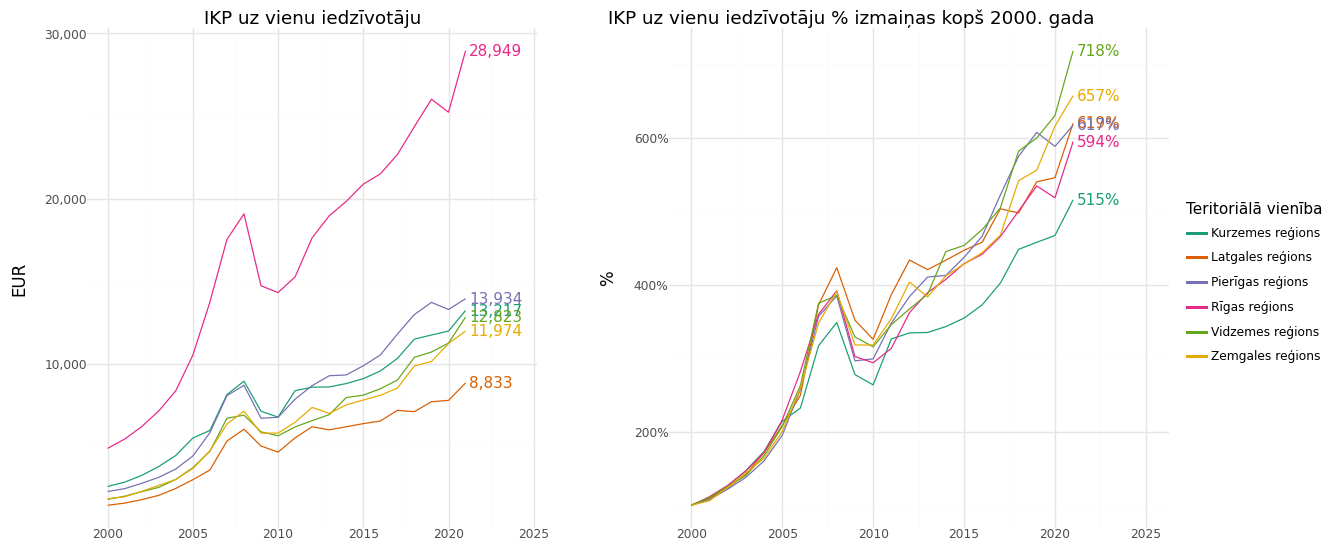

In [523]:
(plot1pw | plot2pw).savefig()

In [524]:
company_data = (
    pl.read_csv("data/UZD010_20241222-170126.csv", separator=";", encoding="utf-8", null_values=["…"])
    .with_columns(
        pl.col("Teritoriālā vienība").str.replace(" \(līdz 01.01.2024.\)", "").str.replace(" \(Rīga\)", "").str.replace("statistiskais ", "")
    )
)

population_data = (
    pl.read_csv("data/IRD081_20241222-170753.csv", separator=";", encoding="utf-8", null_values=["…"])
    .with_columns(
        pl.col("Teritoriālā vienība").str.slice(6).str.replace(" \(līdz 01.01.2024.\)", "").str.replace(" \(Rīga\)", "").str.replace("statistiskais ", "")
    )
)

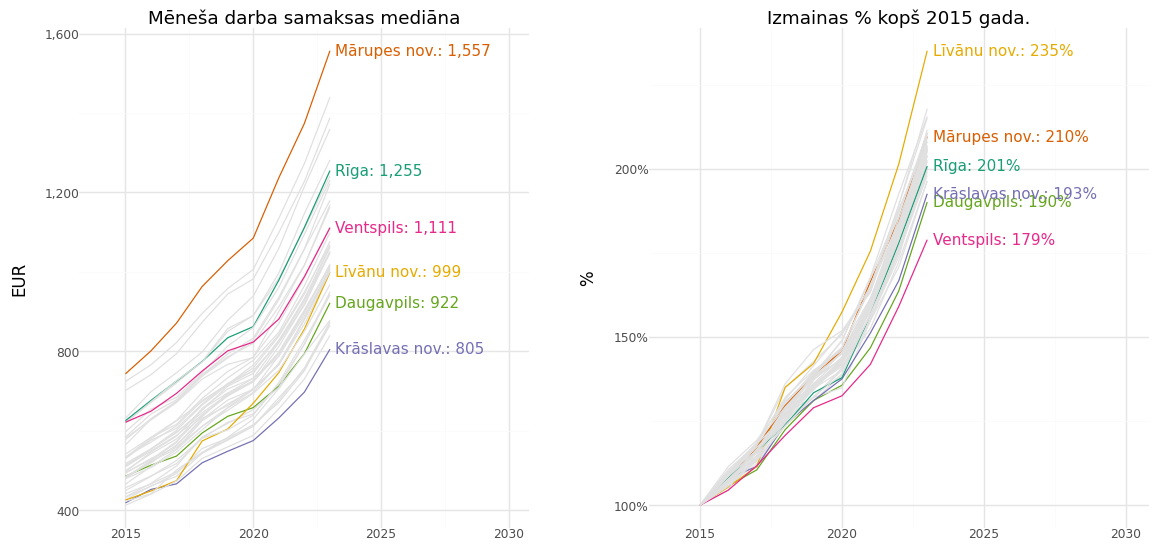

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [525]:
data = pl.from_dataframe(territorial_information[["Teritoriālā vienība", "Gads", "Mēneša darba samaksas mediāna"]])
data_start = (
    data
    .filter(pl.col("Gads") == 2015)
    .with_columns(
        pl.col("Mēneša darba samaksas mediāna").alias("Value on 2015")
    )
    .select("Teritoriālā vienība", "Value on 2015")
)
data = (
    data
    .join(data_start, on="Teritoriālā vienība")
    .with_columns(
        (pl.col("Mēneša darba samaksas mediāna") / pl.col("Value on 2015")).alias("Mēneša darba samaksas mediāna izmainas")
    )
)

highlighted_series = [
            "Rīga",
            "Mārupes nov.",
            "Krāslavas nov.",
            "Ventspils",
            "Daugavpils",
            "Līvānu nov."
        ]
other_series = list(set(data["Teritoriālā vienība"].unique()) - set(highlighted_series))

# Find the last value for each group to annotate
last_values = (
    data
    .filter(pl.col("Gads") == 2023)
    .filter(
        pl.col("Teritoriālā vienība").is_in(highlighted_series)
    )
)



plot1 = (
    ggplot(data, aes(x="Gads", y="Mēneša darba samaksas mediāna", color="Teritoriālā vienība"))
    + scale_color_manual(
        # Use the default color palette for highlighted series and light grey for others
        values={series: scale_color_brewer(type="qualitative", palette="Dark2").palette(len(highlighted_series))[i]
                for i, series in enumerate(highlighted_series)} | {s: "#E0E0E0" for s in other_series}
    )
    + geom_line(show_legend=False)
    + geom_text(
        aes(
            x="Gads",
            y="Mēneša darba samaksas mediāna",
            label=[f"{value[1]}: {value[0]:,.0f}" for value in zip(last_values["Mēneša darba samaksas mediāna"], last_values["Teritoriālā vienība"])]
        ),
        data=last_values,
        show_legend=False,
        nudge_x=0.2,  # Slightly nudge the text to avoid overlap
        ha='left'  # Align text to the left
    )
    + ggtitle("Mēneša darba samaksas mediāna")
    + ylab("EUR")
    + xlab("")
    + theme_minimal()  # Plain white background
    + theme(
        aspect_ratio=0.5,
        figure_size=(10, 5)
    )  # Set aspect ratio to 2:1
    + expand_limits(x=2030)  # Extend space to the right
    + scale_y_continuous(labels=comma_format())  # Format numbers with thousand separators
)
plot1pw = pw.load_ggplot(plot1, figsize=(4.5,5))

# Plot with the specified changes
plot2 = (
    ggplot(data, aes(x="Gads", y="Mēneša darba samaksas mediāna izmainas", color="Teritoriālā vienība"))
    + scale_color_manual(
        # Use the default color palette for highlighted series and light grey for others
        values={series: scale_color_brewer(type="qualitative", palette="Dark2").palette(len(highlighted_series))[i]
                for i, series in enumerate(highlighted_series)} | {s: "#E0E0E0" for s in other_series}
    )
    + geom_line(show_legend=False)
    + geom_text(
        aes(
            x="Gads",
            y="Mēneša darba samaksas mediāna izmainas",
            label=[f"{value[1]}: {value[0]:,.0%}" for value in zip(last_values["Mēneša darba samaksas mediāna izmainas"], last_values["Teritoriālā vienība"])]
        ),
        data=last_values,
        show_legend=False,
        nudge_x=0.2,  # Slightly nudge the text to avoid overlap
        ha='left'  # Align text to the left
    )
    + ggtitle("Izmainas % kopš 2015 gada.")
    + ylab("%")
    + xlab("")
    + theme_minimal()  # Plain white background
    + theme(
        aspect_ratio=0.5,
        figure_size=(10, 5)
    )  # Set aspect ratio to 2:1
    + expand_limits(x=2030)  # Extend space to the right
    + scale_y_continuous(labels=percent_format())  # Format numbers with thousand separators
)
plot2pw = pw.load_ggplot(plot2, figsize=(5,5))
(plot1pw | plot2pw).savefig()

In [528]:
x = "Pašvaldības ieņēmumi: Ieņēmumi no iedzīvotāju ienākuma nodokļa (uz 1 iedz.)"
y = "Ekonomiski aktīvi uzņēmumi (uz 1000 iedz.)"
year = 2023

data = pl.from_dataframe(territorial_information.drop("geometry", axis=1))

def draw_scatterplot(x, y, year):
    filtered_data = data.filter(pl.col("Gads") == year)

    if filtered_data[x].max() <= 1:
        x_scale_formatter = percent_format()
    else:
        x_scale_formatter = number_format()

    if filtered_data[y].max() <= 1:
        y_scale_formatter = percent_format()
    else:
        y_scale_formatter = number_format()

    
    
    return (
        ggplot(
            filtered_data, aes(x, y, label="Teritoriālā vienība")
        )
        + geom_point(show_legend=False, color="grey")
        + geom_label(
            show_legend=False,
            fill="white",
            nudge_x=filtered_data[x].max()*0.01,  # Slightly nudge the text to avoid overlap
            ha='left'  # Align text to the left
        )
        + theme_minimal()  # Plain white background
        + expand_limits(x=filtered_data[x].max()*1.2)  # Extend space to the right
        + scale_y_continuous(labels=y_scale_formatter)
        + scale_x_continuous(labels=x_scale_formatter)
        + theme(figure_size=(12, 6))
    )

In [529]:
interact(draw_scatterplot, x = sorted(list(territorial_information.columns)), y = sorted(list(territorial_information.columns)), year = (2014, 2024, 1))

interactive(children=(Dropdown(description='x', options=('Autoceļu un pašvaldību ielu garums (asfaltbetons)', …

<function __main__.draw_scatterplot(x, y, year)>

In [406]:
residential = gpd.read_file("data/transformed/residential_details_2024.geojson")
from local_functions import territories

In [410]:
minx, miny, maxx, maxy = territories.total_bounds

import numpy as np
from shapely.geometry import Polygon

def create_fishnet(minx, miny, maxx, maxy, cell_size=1000):    
    # Range of x and y coordinates where the squares’ corners will be
    x_coords = np.arange(minx, maxx, cell_size)
    y_coords = np.arange(miny, maxy, cell_size)
    
    polygons = []
    for x in x_coords:
        for y in y_coords:
            # Create square polygon
            polygons.append(
                Polygon([
                    (x, y),
                    (x + cell_size, y),
                    (x + cell_size, y + cell_size),
                    (x, y + cell_size)
                ])
            )
    
    fishnet_gdf = gpd.GeoDataFrame(geometry=polygons, crs=territories.crs)
    return fishnet_gdf

fishnet_gdf = create_fishnet(minx, miny, maxx, maxy)


In [446]:
fishnet_gdf = fishnet_gdf.sjoin(territories, how="inner", predicate="within")[["geometry"]]

In [447]:
residential_fishnet = gpd.sjoin(residential, fishnet_gdf, how="left", predicate="intersects")
residential_fishnet_stats = (
    pl.from_dataframe(residential_fishnet.drop("geometry", axis=1))
    .group_by("index_right")
    .agg(
        (pl.col("Daudzdzīvokļu ēka").cast(pl.Float64) * 46 + pl.col("Savrupmāja").cast(pl.Float64)).sum().alias("Density estimate"),
        pl.col("Attālums līdz ārstam (m)").mean(),
        pl.col("Attālums līdz slimnīcai (m)").mean(),
        pl.col("Attālums līdz poliklīnikai (m)").mean(),
        pl.col("Attālums līdz sabiedriskajam transportam (m)").mean(),
        pl.col("Attālums līdz skolai (m)").mean(),
        pl.col("Attālums līdz bērnudārzam (m)").mean(),
        pl.col("Attālums līdz veikalam (m)").mean()
    )
    .to_pandas()
    .set_index("index_right")
)

In [448]:
residential_fishnet_stats = fishnet_gdf.join(residential_fishnet_stats)

Text(0.5, 1.0, 'Average Distance to Health Centre (by 1km cell)')

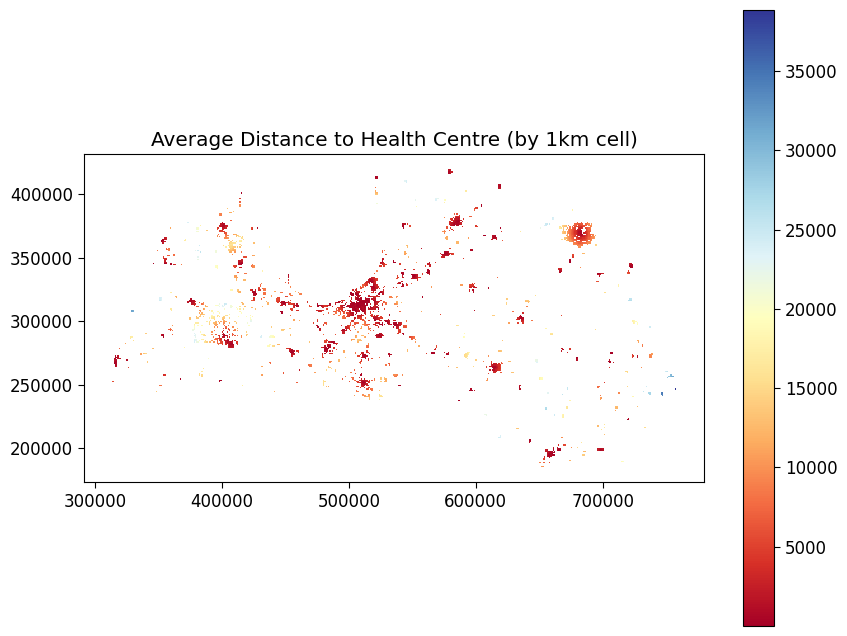

In [449]:
import matplotlib.pyplot as plt

# Plot average distance
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
residential_fishnet_stats.plot(column='Attālums līdz ārstam (m)', ax=ax, legend=True, cmap='RdYlBu')
ax.set_title("Average Distance to Health Centre (by 1km cell)")

Skipping field nodes: unsupported OGR type: 13


<Axes: title={'center': 'Attālums līdz ārstam (m)'}>

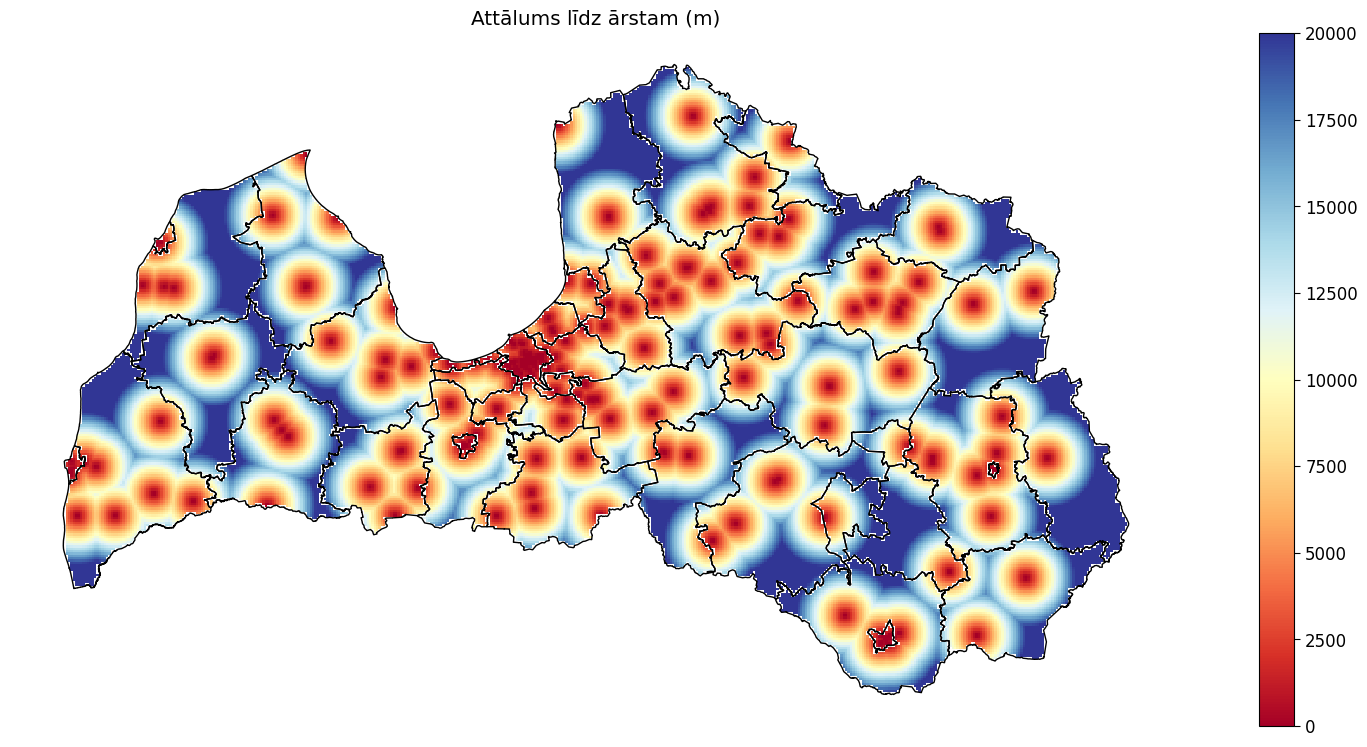

In [469]:
tmp = (
    fishnet_gdf
    .sjoin_nearest(get_healthcare(2024), how="left", distance_col="Attālums līdz ārstam (m)")
)
fig, ax = plt.subplots(1, 1, figsize=(20, 9))
tmp.plot(column='Attālums līdz ārstam (m)', ax=ax, legend=True, cmap='RdYlBu', vmin=0, vmax=20000)
ax.set_axis_off()
ax.set_title("Attālums līdz ārstam (m)")
territories.plot(ax=ax, color="none", edgecolor="black")

Skipping field nodes: unsupported OGR type: 13


<Axes: title={'center': 'Attālums līdz skolai (m)'}>

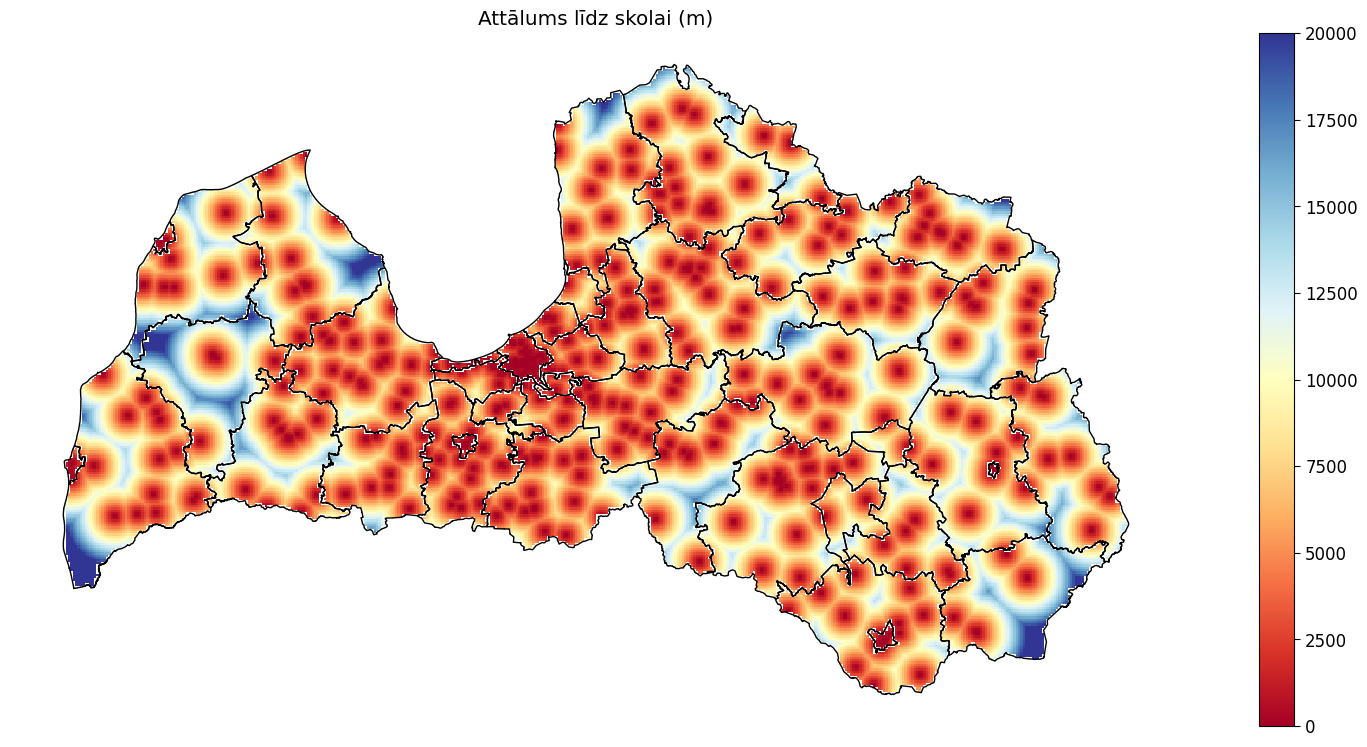

In [468]:
schools = get_schools(2024)
tmp = (
    fishnet_gdf
    .sjoin_nearest(schools[schools.amenity == "school"], how="left", distance_col="Attālums līdz skolai (m)")
)
fig, ax = plt.subplots(1, 1, figsize=(20, 9))
tmp.plot(column='Attālums līdz skolai (m)', ax=ax, legend=True, cmap='RdYlBu', vmin=0, vmax=20000)
ax.set_axis_off()
ax.set_title("Attālums līdz skolai (m)")
territories.plot(ax=ax, color="none", edgecolor="black")

Skipping field nodes: unsupported OGR type: 13


<Axes: title={'center': 'Attālums līdz bērnudārzam (m)'}>

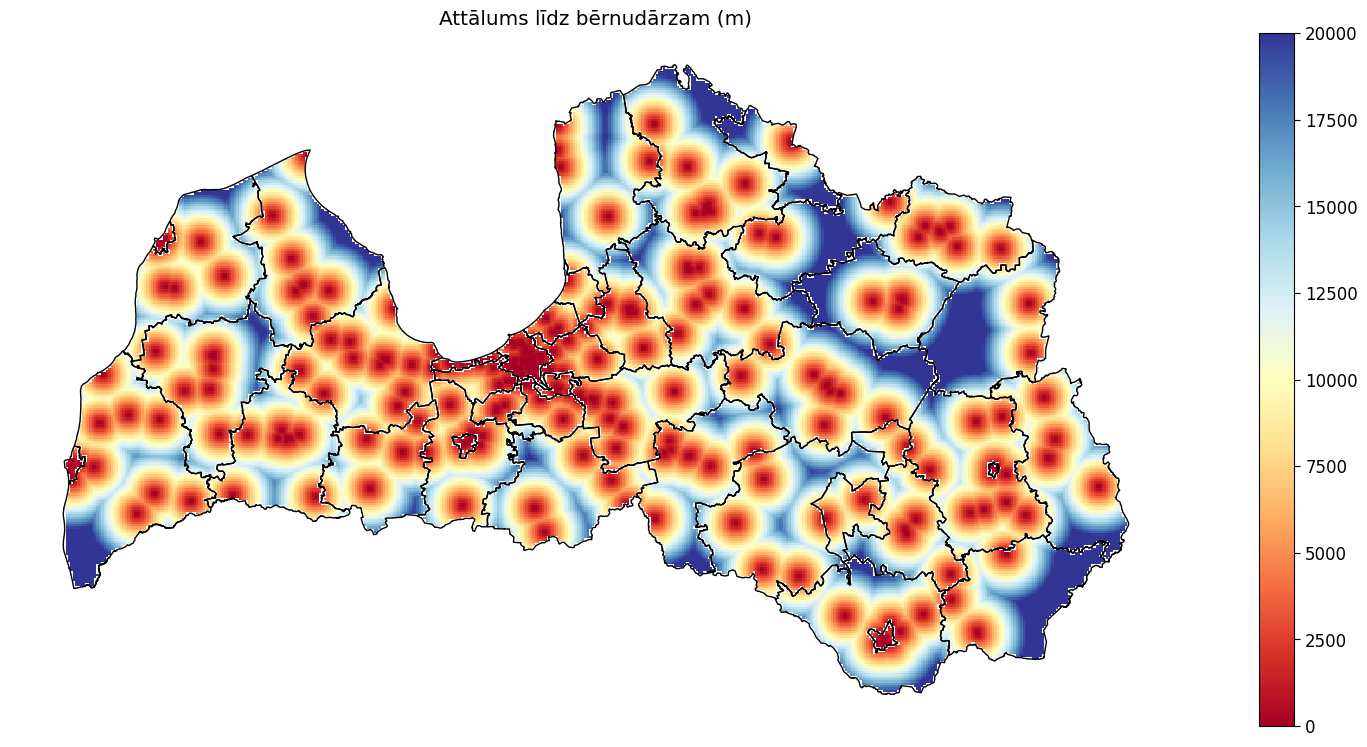

In [467]:
schools = get_schools(2024)
tmp = (
    fishnet_gdf
    .sjoin_nearest(schools[schools.amenity == "kindergarten"], how="left", distance_col="Attālums līdz bērnudārzam (m)")
)
fig, ax = plt.subplots(1, 1, figsize=(20, 9))
tmp.plot(column='Attālums līdz bērnudārzam (m)', ax=ax, legend=True, cmap='RdYlBu', vmin=0, vmax=20000)
ax.set_axis_off()
ax.set_title("Attālums līdz bērnudārzam (m)")
territories.plot(ax=ax, color="none", edgecolor="black")

Skipping field nodes: unsupported OGR type: 13


<Axes: title={'center': 'Attālums līdz sabiedriskajam transportam (m)'}>

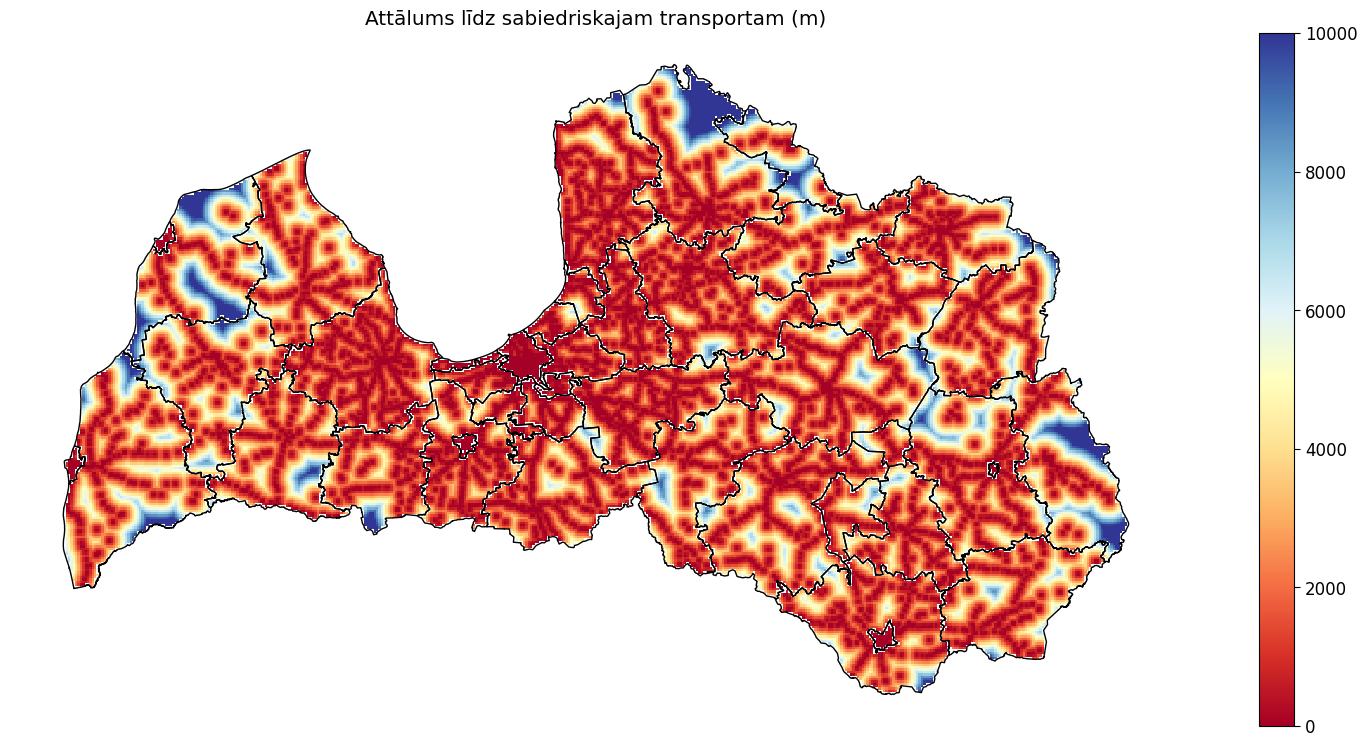

In [474]:
public_transport = get_public_transport(2024)
tmp = (
    fishnet_gdf
    .sjoin_nearest(public_transport, how="left", distance_col="Attālums līdz sabiedriskajam transportam (m)")
)
fig, ax = plt.subplots(1, 1, figsize=(20, 9))
tmp.plot(column='Attālums līdz sabiedriskajam transportam (m)', ax=ax, legend=True, cmap='RdYlBu', vmin=0, vmax=10000)
ax.set_axis_off()
ax.set_title("Attālums līdz sabiedriskajam transportam (m)")
territories.plot(ax=ax, color="none", edgecolor="black")

Skipping field nodes: unsupported OGR type: 13


<Axes: title={'center': 'Attālums līdz veikalam (m)'}>

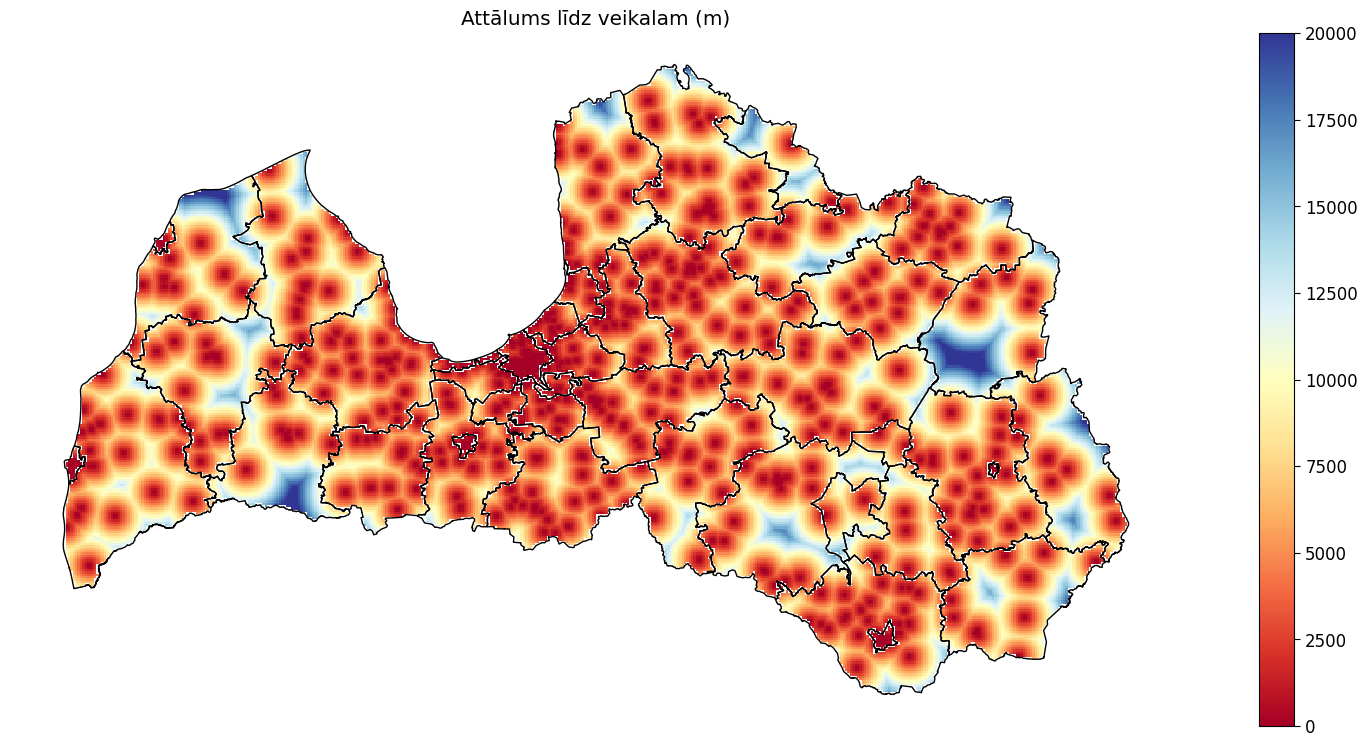

In [498]:
shops = get_shops(2024)
tmp = (
    fishnet_gdf
    .sjoin_nearest(shops, how="left", distance_col="Attālums līdz veikalam (m)")
)
fig, ax = plt.subplots(1, 1, figsize=(20, 9))
tmp.plot(column='Attālums līdz veikalam (m)', ax=ax, legend=True, cmap='RdYlBu', vmin=0, vmax=20000)
ax.set_axis_off()
ax.set_title("Attālums līdz veikalam (m)")
territories.plot(ax=ax, color="none", edgecolor="black")

Skipping field nodes: unsupported OGR type: 13
Skipping field nodes: unsupported OGR type: 13


0           Annotation(689386, 367560, 'Alūksnes nov.')
1             Annotation(645154, 249894, 'Līvānu nov.')
2           Annotation(657141, 340579, 'Gulbenes nov.')
3          Annotation(371234, 355046, 'Ventspils nov.')
4             Annotation(615951, 398896, 'Valkas nov.')
5          Annotation(521323, 303589, 'Salaspils nov.')
6                 Annotation(482612, 278576, 'Jelgava')
7                 Annotation(705503, 267915, 'Rēzekne')
8                 Annotation(481405, 312923, 'Jūrmala')
9               Annotation(355813, 365077, 'Ventspils')
10                   Annotation(507444, 314947, 'Rīga')
11                Annotation(317424, 270202, 'Liepāja')
12    Annotation(339539, 267879, 'Dienvidkurzemes no...
13          Annotation(375197, 306459, 'Kuldīgas nov.')
14            Annotation(404802, 275319, 'Saldus nov.')
15             Annotation(414738, 357624, 'Talsu nov.')
16            Annotation(440424, 311704, 'Tukuma nov.')
17           Annotation(446982, 267516, 'Dobeles

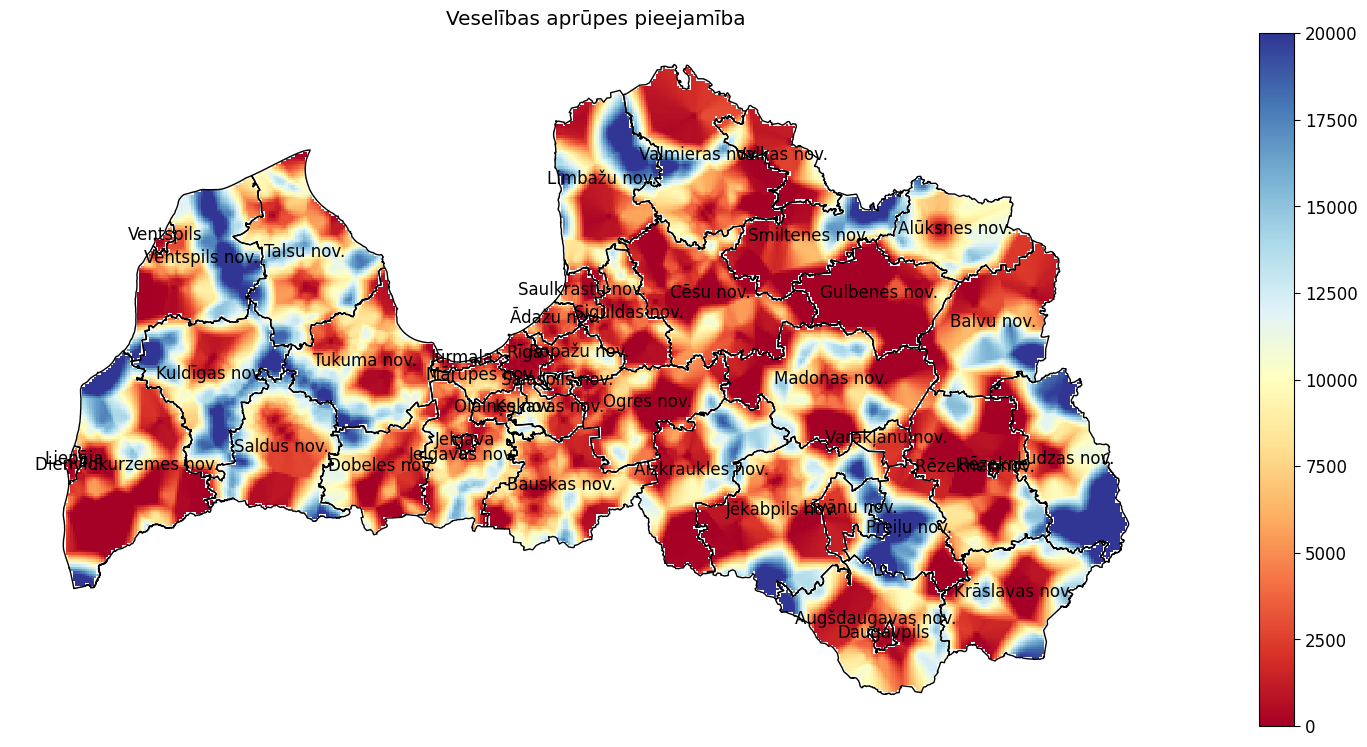

In [493]:
tmp = (
    fishnet_gdf
    .sjoin_nearest(get_residential(2024), how="left", distance_col="Attālums līdz dzivojamas ekas (m)").drop("index_right", axis=1)
    .sjoin_nearest(get_healthcare(2024), how="left", distance_col="Attālums līdz ārstam (m)")
)
tmp["difference"] = tmp["Attālums līdz ārstam (m)"] - tmp["Attālums līdz dzivojamas ekas (m)"]
fig, ax = plt.subplots(1, 1, figsize=(20, 9))
tmp.plot(column='difference', ax=ax, legend=True, cmap='RdYlBu', vmin=0, vmax=20000)
ax.set_axis_off()
ax.set_title("Veselības aprūpes pieejamība")
territories.plot(ax=ax, color="none", edgecolor="black")
territories.apply(lambda x: ax.annotate(text=x["Teritoriālā vienība"], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)

Skipping field nodes: unsupported OGR type: 13
Skipping field nodes: unsupported OGR type: 13


<Axes: title={'center': 'Izglītības pieejamība'}>

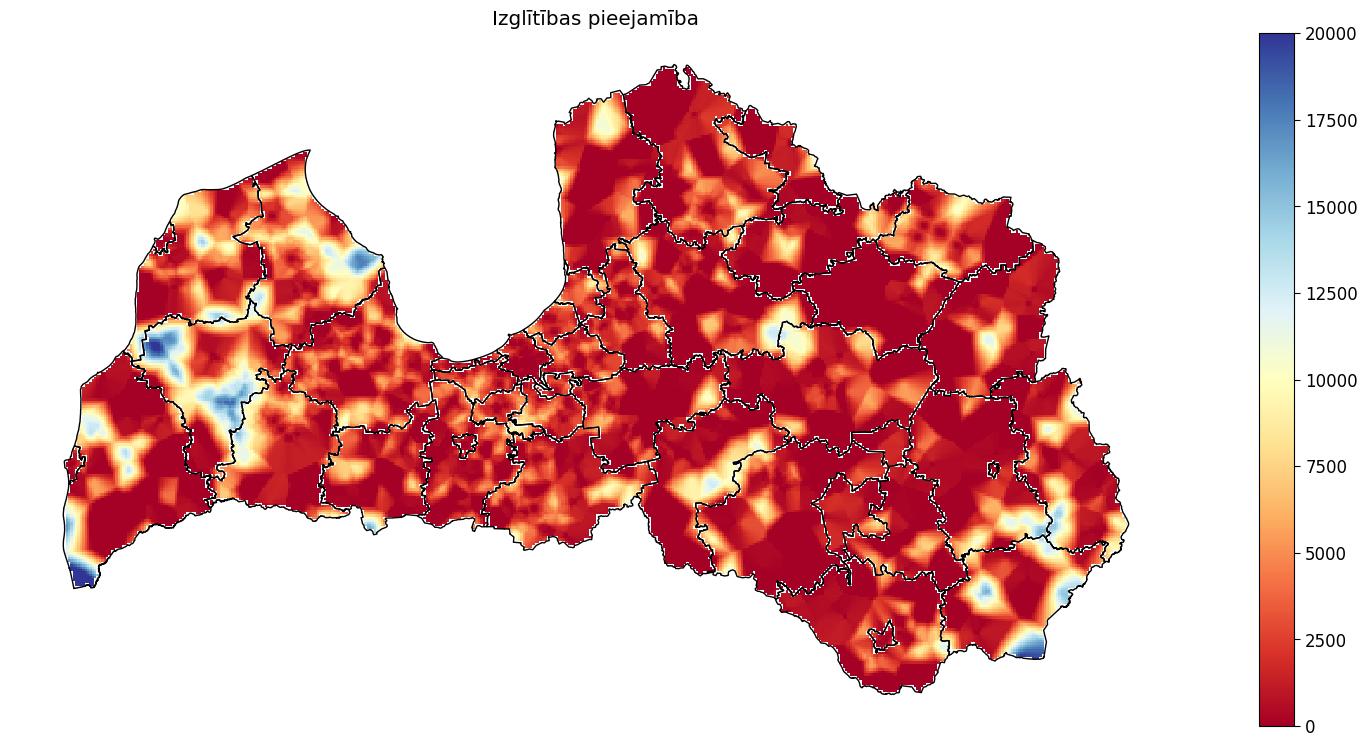

In [492]:
schools = get_schools(2024)
tmp = (
    fishnet_gdf
    .sjoin_nearest(get_residential(2024), how="left", distance_col="Attālums līdz dzivojamas ekas (m)").drop("index_right", axis=1)
    .sjoin_nearest(schools[schools.amenity == "school"], how="left", distance_col="Attālums līdz skolai (m)")
)
tmp["difference"] = tmp["Attālums līdz skolai (m)"] - tmp["Attālums līdz dzivojamas ekas (m)"]
fig, ax = plt.subplots(1, 1, figsize=(20, 9))
tmp.plot(column='difference', ax=ax, legend=True, cmap='RdYlBu', vmin=0, vmax=20000)
ax.set_axis_off()
ax.set_title("Izglītības pieejamība")
territories.plot(ax=ax, color="none", edgecolor="black")
#territories.apply(lambda x: ax.annotate(text=x["Teritoriālā vienība"], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)

In [ ]:
schools = get_schools(2024)
tmp = (
    fishnet_gdf
    .sjoin_nearest(get_residential(2024), how="left", distance_col="Attālums līdz dzivojamas ekas (m)").drop("index_right", axis=1)
    .sjoin_nearest(schools[schools.amenity == "school"], how="left", distance_col="Attālums līdz skolai (m)")
)
tmp["difference"] = tmp["Attālums līdz skolai (m)"] - tmp["Attālums līdz dzivojamas ekas (m)"]
fig, ax = plt.subplots(1, 1, figsize=(20, 9))
tmp.plot(column='difference', ax=ax, legend=True, cmap='RdYlBu', vmin=0, vmax=20000)
ax.set_axis_off()
ax.set_title("Izglītības pieejamība")
territories.plot(ax=ax, color="none", edgecolor="black")
#territories.apply(lambda x: ax.annotate(text=x["Teritoriālā vienība"], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)

Skipping field nodes: unsupported OGR type: 13
Skipping field nodes: unsupported OGR type: 13


0           Annotation(689386, 367560, 'Alūksnes nov.')
1             Annotation(645154, 249894, 'Līvānu nov.')
2           Annotation(657141, 340579, 'Gulbenes nov.')
3          Annotation(371234, 355046, 'Ventspils nov.')
4             Annotation(615951, 398896, 'Valkas nov.')
5          Annotation(521323, 303589, 'Salaspils nov.')
6                 Annotation(482612, 278576, 'Jelgava')
7                 Annotation(705503, 267915, 'Rēzekne')
8                 Annotation(481405, 312923, 'Jūrmala')
9               Annotation(355813, 365077, 'Ventspils')
10                   Annotation(507444, 314947, 'Rīga')
11                Annotation(317424, 270202, 'Liepāja')
12    Annotation(339539, 267879, 'Dienvidkurzemes no...
13          Annotation(375197, 306459, 'Kuldīgas nov.')
14            Annotation(404802, 275319, 'Saldus nov.')
15             Annotation(414738, 357624, 'Talsu nov.')
16            Annotation(440424, 311704, 'Tukuma nov.')
17           Annotation(446982, 267516, 'Dobeles

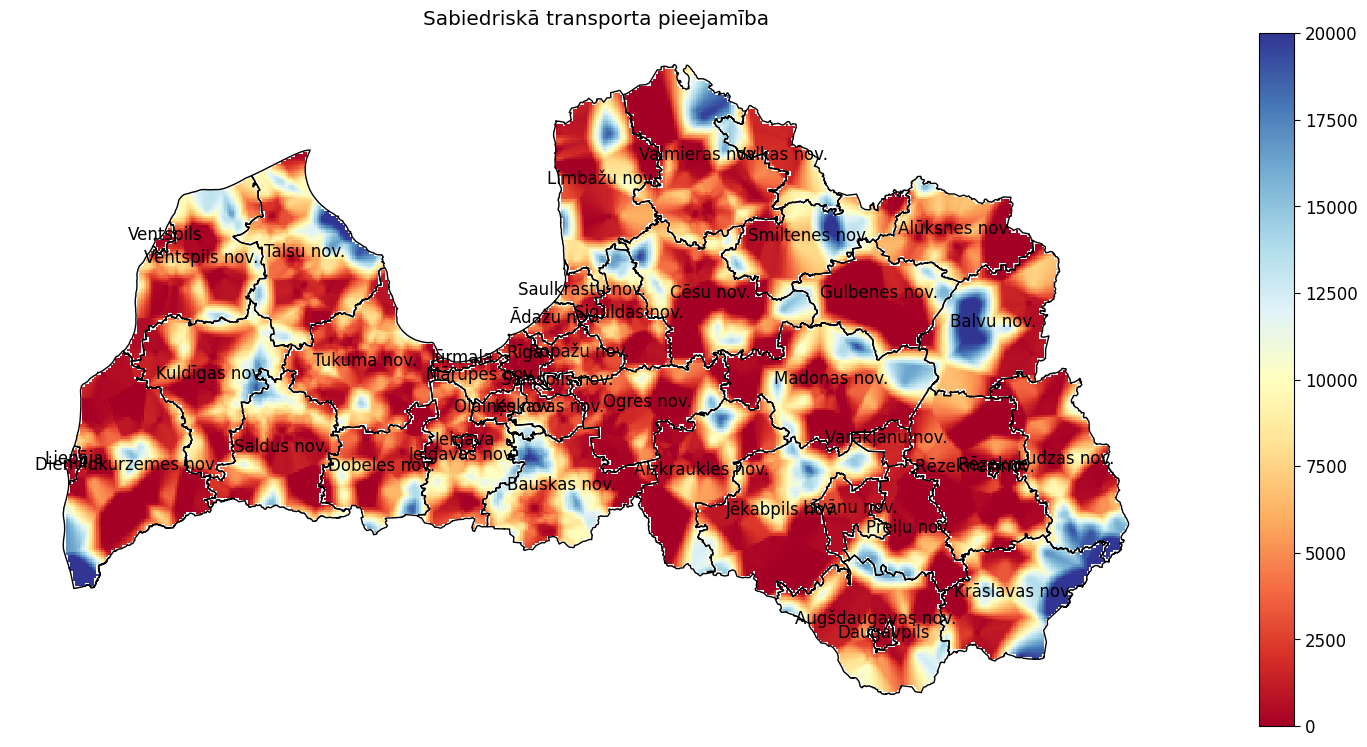

In [499]:
schools = get_schools(2024)
tmp = (
    fishnet_gdf
    .sjoin_nearest(get_residential(2024), how="left", distance_col="Attālums līdz dzivojamas ekas (m)").drop("index_right", axis=1)
    .sjoin_nearest(schools[schools.amenity == "kindergarten"], how="left", distance_col="Attālums līdz bērnudārzam (m)")
)
tmp["difference"] = tmp["Attālums līdz bērnudārzam (m)"] - tmp["Attālums līdz dzivojamas ekas (m)"]
fig, ax = plt.subplots(1, 1, figsize=(20, 9))
tmp.plot(column='difference', ax=ax, legend=True, cmap='RdYlBu', vmin=0, vmax=20000)
ax.set_axis_off()
ax.set_title("Pirmsskolas izglītības pieejamība")
territories.plot(ax=ax, color="none", edgecolor="black")
territories.apply(lambda x: ax.annotate(text=x["Teritoriālā vienība"], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)

Skipping field nodes: unsupported OGR type: 13
Skipping field nodes: unsupported OGR type: 13


<Axes: title={'center': 'Sabiedriskā transporta pieejamība'}>

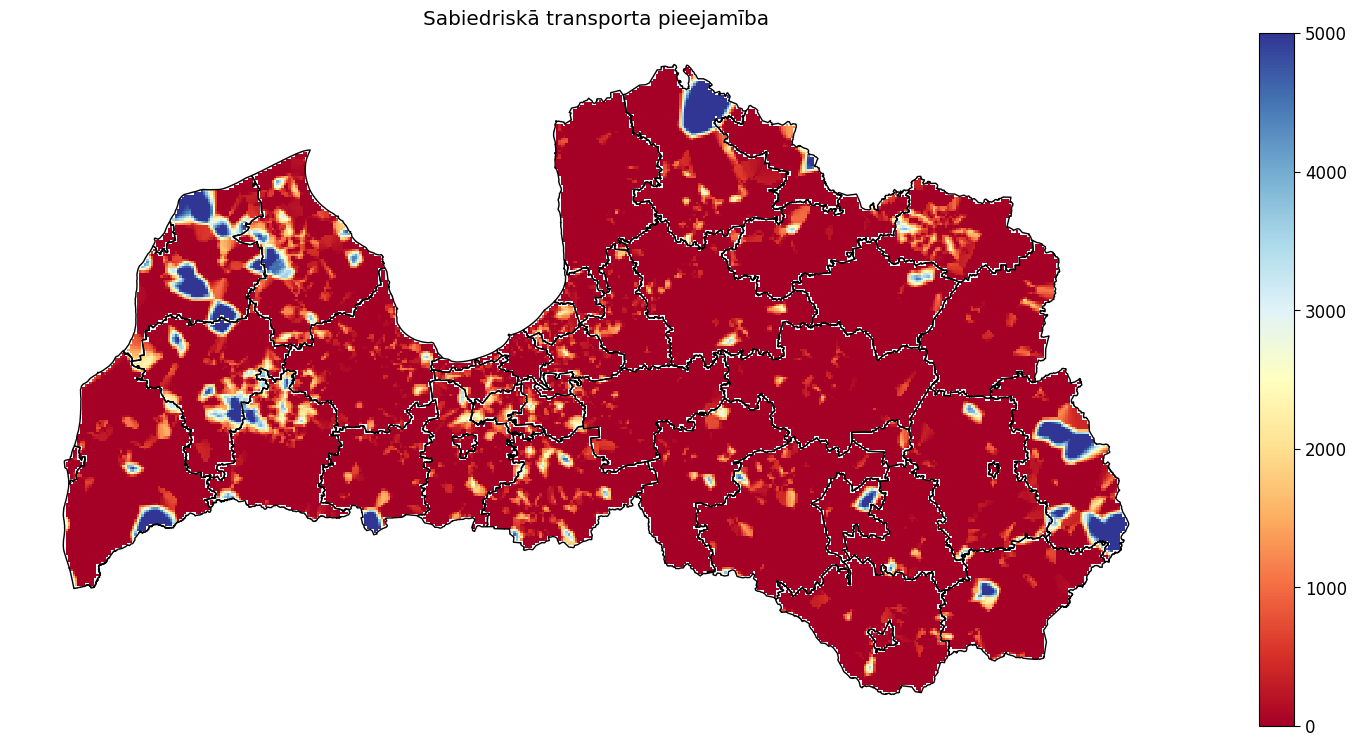

In [506]:
tmp = (
    fishnet_gdf
    .sjoin_nearest(get_residential(2024), how="left", distance_col="Attālums līdz dzivojamas ekas (m)").drop("index_right", axis=1)
    .sjoin_nearest(get_public_transport(2024), how="left", distance_col="Attālums līdz sabiedriskajam transportam (m)")
)
tmp["difference"] = tmp["Attālums līdz sabiedriskajam transportam (m)"] - tmp["Attālums līdz dzivojamas ekas (m)"]
fig, ax = plt.subplots(1, 1, figsize=(20, 9))
tmp.plot(column='difference', ax=ax, legend=True, cmap='RdYlBu', vmin=0, vmax=5000)
ax.set_axis_off()
ax.set_title("Sabiedriskā transporta pieejamība")
territories.plot(ax=ax, color="none", edgecolor="black")
#territories.apply(lambda x: ax.annotate(text=x["Teritoriālā vienība"], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)

Skipping field nodes: unsupported OGR type: 13
Skipping field nodes: unsupported OGR type: 13


<Axes: title={'center': 'Tirdzniecības pieejamība'}>

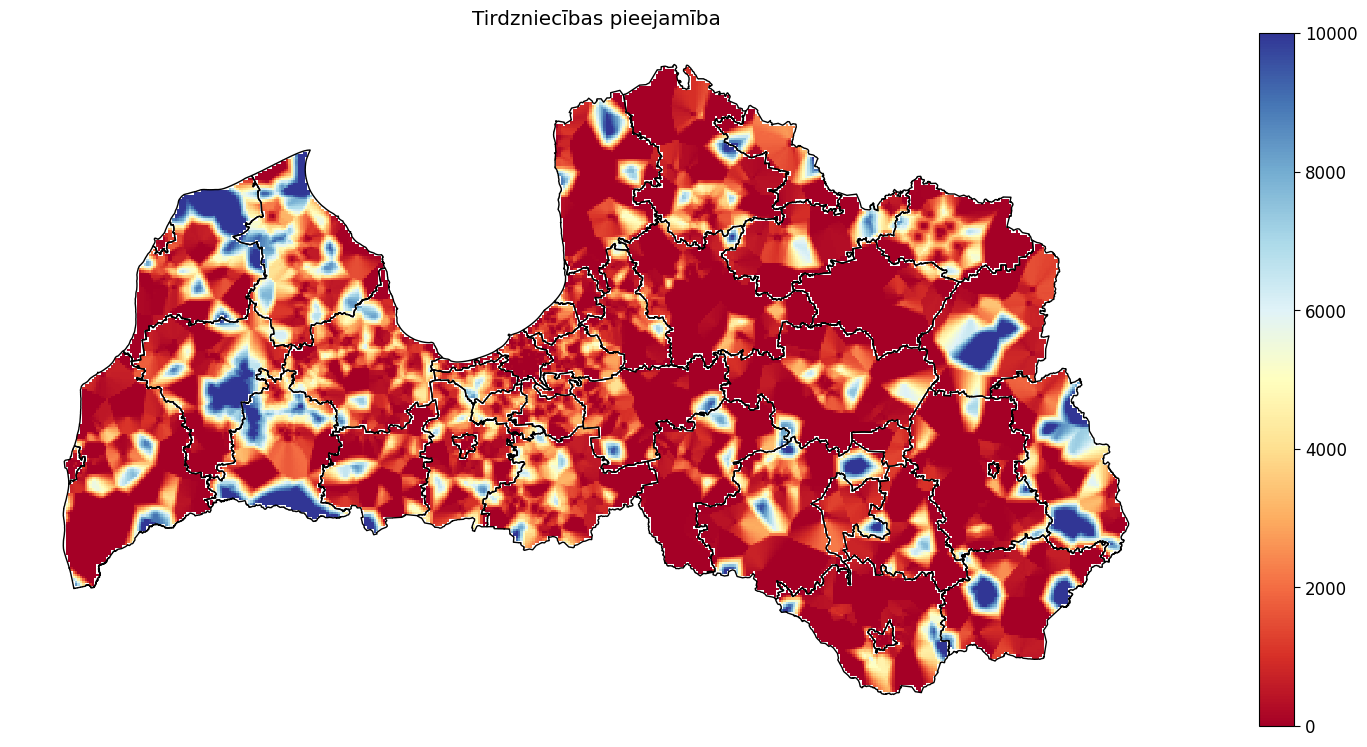

In [507]:
tmp = (
    fishnet_gdf
    .sjoin_nearest(get_residential(2024), how="left", distance_col="Attālums līdz dzivojamas ekas (m)").drop("index_right", axis=1)
    .sjoin_nearest(get_shops(2024), how="left", distance_col="Attālums līdz veikalam (m)")
)
tmp["difference"] = tmp["Attālums līdz veikalam (m)"] - tmp["Attālums līdz dzivojamas ekas (m)"]
fig, ax = plt.subplots(1, 1, figsize=(20, 9))
tmp.plot(column='difference', ax=ax, legend=True, cmap='RdYlBu', vmin=0, vmax=10000)
ax.set_axis_off()
ax.set_title("Tirzniecības pieejamība")
territories.plot(ax=ax, color="none", edgecolor="black")
#territories.apply(lambda x: ax.annotate(text=x["Teritoriālā vienība"], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)